# ✍️ #30DayMapChallenge - Day 19: Typography

**Map for day 19 of the [#30DayMapChallenge](https://30daymapchallenge.com/) 2024, created by Náttúrufræðistofnun.**

---

### Overview
This map visualizes Iceland's most common placenames as a **word cloud**. The map was created in Python using the **WordCloud** package and is based on datasets from Náttúrufræðistofnun: **Örnefni** and **Strandlína**.

In the word cloud, the **size of each word reflects its frequency**—the larger the word, the more frequently it appears in Iceland's placenames. This provides a unique perspective on Icelandic geography and naming conventions.

### How to Use
Users can try creating their own word cloud map by running the provided examples in **Kaggle** or **Colab**. It's a simple way to explore Icelandic placenames and learn more about Python-based mapping tools.

| Try the code via free cloud platforms: | [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/lmi/30DayMapChallenge/master?filepath=/Day-19/Day19-Typography.ipynb) | [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/lmi/30DayMapChallenge/blob/master/Day-19/Day19-Typography.ipynb) | [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lmi/30DayMapChallenge/blob/master/Day-19/Day19-Typography.ipynb) |
|---|---|---|---|

---

### Attribution
- **License**: This notebook is published under **CC BY 4.0**.
- **Citation**: "*Credits: Náttúrufræðistofnun*"
- **Author**: Marco Pizzolato
- **Font**: [Eagle Lake](https://fonts.google.com/specimen/Eagle+Lake)
- **Data Sources**: [Örnefni](https://gatt.natt.is/geonetwork/srv/ice/catalog.search#/metadata/AED93950-4043-4D42-B8F8-C118611F33C9) and [Strandlína](https://gatt.natt.is/geonetwork/srv/ice/catalog.search#/metadata/FE3E66F8-7749-409A-8795-02207CE27613) from Náttúrufræðistofnun
- **Created in**: Python with the [WordCloud](https://amueller.github.io/word_cloud/index.html) package by Andreas Mueller

---

**This word cloud map provides a typographic exploration of Iceland’s placenames, blending data visualization with geographical storytelling.**

![Day 19 - Typography](Day19-Typography_ISL.png)


## Install and import

In [27]:
#!pip install wordcloud multidict

In [2]:
import requests
import leafmap.foliumap as leafmap
import geopandas as gpd
import os
import wordcloud
import pandas as pd
import numpy as np
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from shapely.geometry import mapping
from rasterio.features import rasterize
import rasterio
from multidict import MultiDict
import multidict
import re

## Get outline of Iceland
More info: [Lýsigagnagátt](https://gatt.natt.is/geonetwork/srv/ice/catalog.search#/metadata/FE3E66F8-7749-409A-8795-02207CE27613)

In [3]:
url_mork = "https://gis.natt.is/geoserver/IS_50V/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=IS_50V%3Astrandlina_flakar&maxFeatures=100000&outputFormat=application%2Fx-gpkg"
# Download the GeoPackage
response = requests.get(url_mork)
with open("mork.gpkg", "wb") as f:
    f.write(response.content)

mork = gpd.read_file("mork.gpkg").to_crs(3857)

In [4]:
# Add a new column to the GeoDataFrame for the area of each geometry
mork["area"] = mork.geometry.area  # The area is calculated in the CRS units (e.g., square meters if using EPSG:3857)

# Filter the row with the largest area into a new GeoDataFrame
largest_area_gdf = mork.loc[mork["area"].idxmax()].to_frame().T

# Convert back to a GeoDataFrame if needed
largest_area_gdf = gpd.GeoDataFrame(largest_area_gdf, geometry="geometry", crs=mork.crs)


<Axes: >

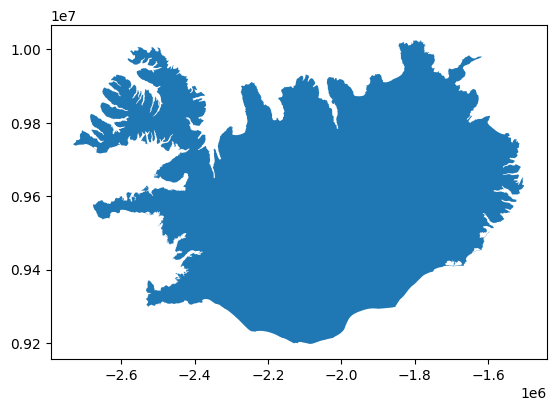

In [5]:
largest_area_gdf.plot()

## Make mask raster from outline

In [6]:
# Filter for the desired polygon (replace with your filter criteria)
polygon = largest_area_gdf.geometry.unary_union 

# Define raster properties
bounds = polygon.bounds  # Bounding box of the polygon
resolution = 100  # Desired resolution in meters per pixel
width = int((bounds[2] - bounds[0]) / resolution)  # Number of pixels in x
height = int((bounds[3] - bounds[1]) / resolution)  # Number of pixels in y

# Define the transform for the raster
transform = rasterio.transform.from_bounds(*bounds, width, height)

# Create a blank raster array (background filled with 0)
raster = np.zeros((height, width), dtype=np.uint8)

# Burn the polygon into the raster with a value of 1
raster = rasterize(
    [(polygon, 0)],  # List of (geometry, value)
    out_shape=raster.shape,
    transform=transform,
    fill=1,  # Background value
    dtype=np.uint8  # Data type
)

# Save the raster as a PNG image
plt.imsave("mask.png", raster, cmap="gray", format="png")

## Get placenames in Iceland
More info: [Lýsigagnagátt](https://gatt.natt.is/geonetwork/srv/ice/catalog.search#/metadata/AED93950-4043-4D42-B8F8-C118611F33C9)

In [7]:
# URLs of the GeoPackage files
url_points = "https://gis.natt.is/geoserver/IS_50V/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=IS_50V%3Aornefni_punktar&maxFeatures=100000&outputFormat=application%2Fx-gpkg"
url_lines = "https://gis.natt.is/geoserver/IS_50V/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=IS_50V%3Aornefni_linur&maxFeatures=100000&outputFormat=application%2Fx-gpkg"
url_polygons = "https://gis.natt.is/geoserver/IS_50V/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=IS_50V%3Aornefni_flakar&maxFeatures=100000&outputFormat=application%2Fx-gpkg"

In [8]:
# Download the GeoPackage
response = requests.get(url_points)
with open("points.gpkg", "wb") as f:
    f.write(response.content)

# Download the GeoPackage
response = requests.get(url_lines)
with open("lines.gpkg", "wb") as f:
    f.write(response.content)

# Download the GeoPackage
response = requests.get(url_polygons)
with open("polygons.gpkg", "wb") as f:
    f.write(response.content)

# Load the GeoPackage files into GeoDataFrames
points = gpd.read_file("points.gpkg").to_crs(3857)
lines = gpd.read_file("lines.gpkg").to_crs(3857)
polygons = gpd.read_file("polygons.gpkg").to_crs(3857)

In [9]:
# Convert geometries to centroids
line_centroids = lines.copy()
line_centroids["geometry"] = lines.geometry.centroid

polygon_centroids = polygons.copy()
polygon_centroids["geometry"] = polygons.geometry.centroid

In [10]:
# Combine all in one GeoDataFrame
labels = gpd.GeoDataFrame(
    pd.concat([line_centroids, polygon_centroids, points], ignore_index=True),
    crs=lines.crs
)

## Match the labels inside Iceland

In [11]:
# Spatially join the labels GeoDataFrame with mork
labels_with_isl = gpd.sjoin(labels, mork, how="inner", predicate="within")

# Group by label and count occurrences
label_counts = (
    labels_with_isl.groupby("ornefni")  # Replace "ornefni" with the column containing the labels
    .size()
    .reset_index(name="count")
)

# Sort by occurrence in descending order
labels_selection = label_counts.sort_values(by="count", ascending=False)

# Save or display results
print(labels_selection)

          ornefni  count
70654     Stekkur    579
7636   Bæjarlækur    499
12124      Einbúi    478
57495    Nátthagi    253
64118  Sjónarhóll    251
...           ...    ...
33299   Háeggjaás      1
33298    Háeggjar      1
33297       Háegg      1
33296   Hádýisgil      1
89653    Þýðhólmi      1

[89654 rows x 2 columns]


In [12]:
# Select label amount
n = 100 # top 100 labels
top_labels = labels_selection[labels_selection["count"] > n]

In [ ]:
top_10 = top_labels[0:10]
top_10

,ornefni,count
70654,Stekkur,579
7636,Bæjarlækur,499
12124,Einbúi,478
57495,Nátthagi,253
64118,Sjónarhóll,251
22573,Grásteinn,225
72154,Stórhóll,210
7494,Bæjargil,207
39307,Kinn,186
34511,Hólar,174


## Make word dictionary with frequency

In [14]:
# Define the output file path
output_file = "words.txt"

# Save the filtered labels to a text file
with open(output_file, "w") as file:
    for _, row in top_labels.iterrows():
        file.write(f"{row['ornefni']} ")

In [ ]:
def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", text):
            continue
        val = tmpDict.get(text, 0)
        #tmpDict[text.lower()] = val + 1 # to make it lower characters
        tmpDict[text] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict

In [42]:
text = open('words.txt', encoding='utf-8')
text = text.read()
frequency = getFrequencyDictForText(text)

## Get beautiful font
Search more fonts here: https://fonts.google.com/ 

In [18]:
# URL of the TTF font
font_url = 'https://fonts.gstatic.com/s/eaglelake/v24/ptRMTiqbbuNJDOiKj9wG5O7yKQNute8.ttf' #"https://fonts.gstatic.com/s/doto/v1/t5tJIRMbNJ6TQG7Il_EKPqP9zTnvqqGNcuvLMt1JIphFuOKez0WSvrlpgw.ttf"

# Download the font
font_path = "font.ttf"
response = requests.get(font_url)
with open(font_path, "wb") as f:
    f.write(response.content)

print(f"Font downloaded and saved to {font_path}")

Font downloaded and saved to font.ttf


## Make Word Cloud

In [46]:
from PIL import Image
def makeWordCloud(text, mask_img, font_path, color = False):
    mask = np.array(Image.open(mask_img))

    wc = WordCloud(background_color="white", max_words=1000, mask=mask, contour_width=8, contour_color='steelblue', font_path=font_path, random_state=1)
    # generate word cloud
    wc.generate_from_frequencies(text)

    image_colors = 0
    if color == True:
        image_colors = ImageColorGenerator(mask_img)

    return wc, image_colors

In [47]:
wc, color = makeWordCloud(frequency, 'mask.png', font_path)

## Plot

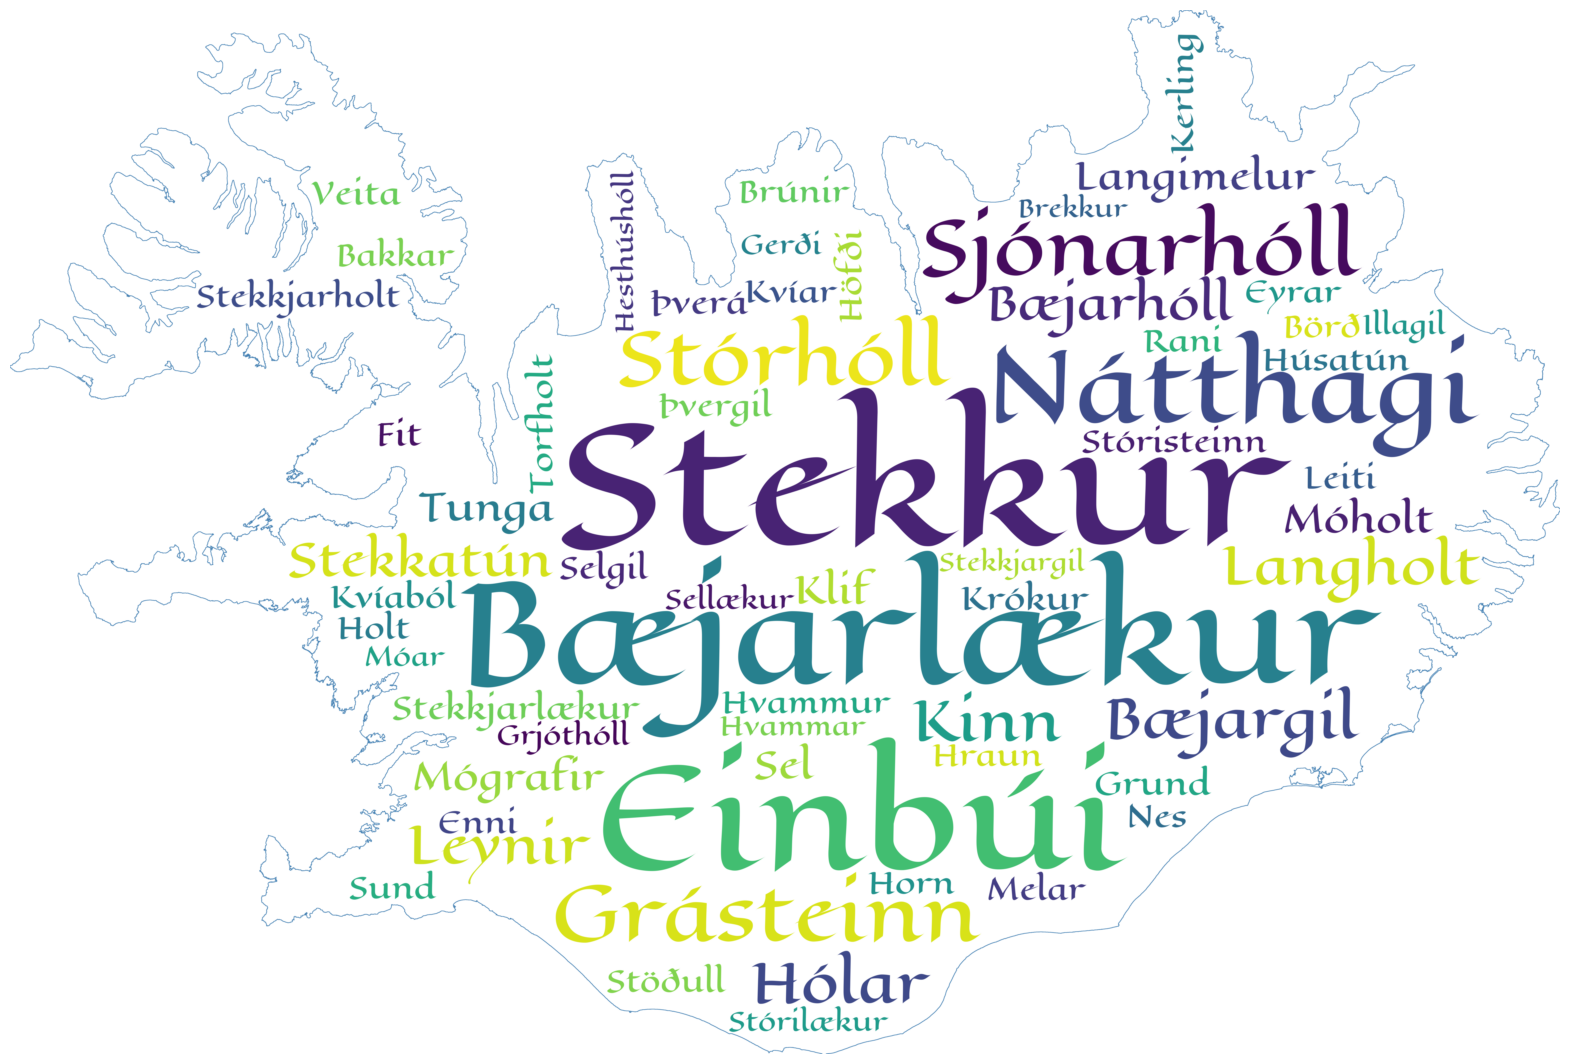

In [48]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(wc, interpolation="bilinear")
ax.axis("off")
plt.show()

## Choosing a different color
Find more here: https://matplotlib.org/stable/gallery/color/colormap_reference.html \
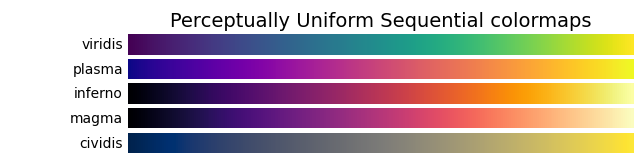\
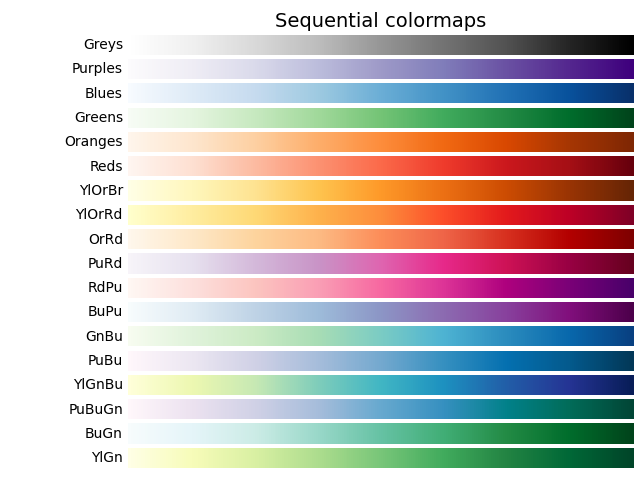

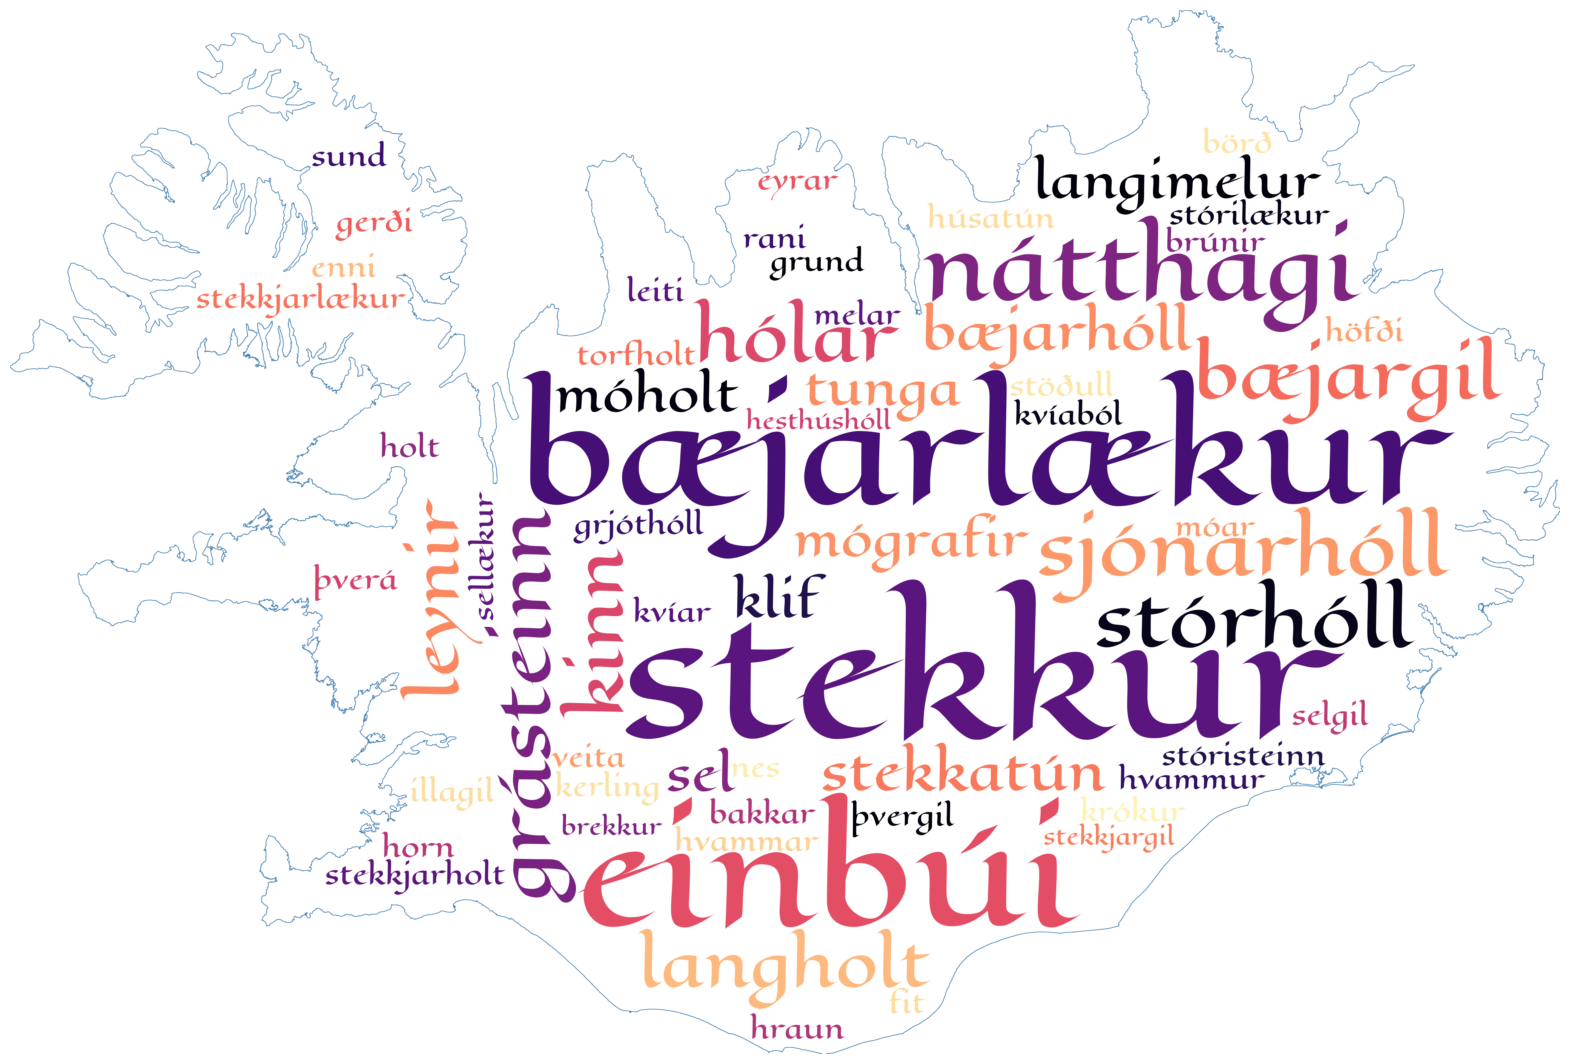

In [ ]:
import matplotlib.cm as cm

# Custom color function using colormap
def coloring(word, font_size, position, orientation, random_state=None, **kwargs):
    # Use the colormap to generate colors
    colormap = cm.magma # Change here
    # Generate a random value for the colormap (between 0 and 1)
    color_value = np.random.random()
    # Map the random value to the colormap
    r, g, b = [int(c * 255) for c in colormap(color_value)[:3]]  # Get RGB only
    return f"rgb({r}, {g}, {b})"

# Recolor the word cloud using the custom color function
wc_colored = wc.recolor(color_func=coloring)

# Plot the word cloud
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(wc_colored, interpolation="bilinear")
ax.axis("off")
plt.show()

In [ ]:
# Color if your mask has a color scheme
"""image_colors = ImageColorGenerator('mask.png')
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")"""

## Save file

In [49]:
# Save the figure with padding around it
fig.savefig("Day19-Typography.png", bbox_inches="tight", pad_inches=2, dpi=600)